<a href="https://colab.research.google.com/github/Jeongyoon-Jang/SOLUX_summer_data/blob/master/3-4%EC%A3%BC%EC%B0%A8/%EC%BA%90%EA%B8%80%EC%8B%A4%EC%8A%B5_11(8%EC%9B%94_16%EC%9D%BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline # 노트북 안에 그래프 그리기 위해

mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨지는 문제 방지

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/train.csv", parse_dates=["datetime"])
train.shape # train 데이터 불러옴

(10886, 12)

In [5]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/test.csv", parse_dates=["datetime"])
test.shape # test 데이터 불러옴

(6493, 9)

In [6]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape # datetime을 세분화 해서 column 담아줌

(10886, 19)

In [7]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape # datetime을 세분화해서 column을 담아줌

(6493, 16)

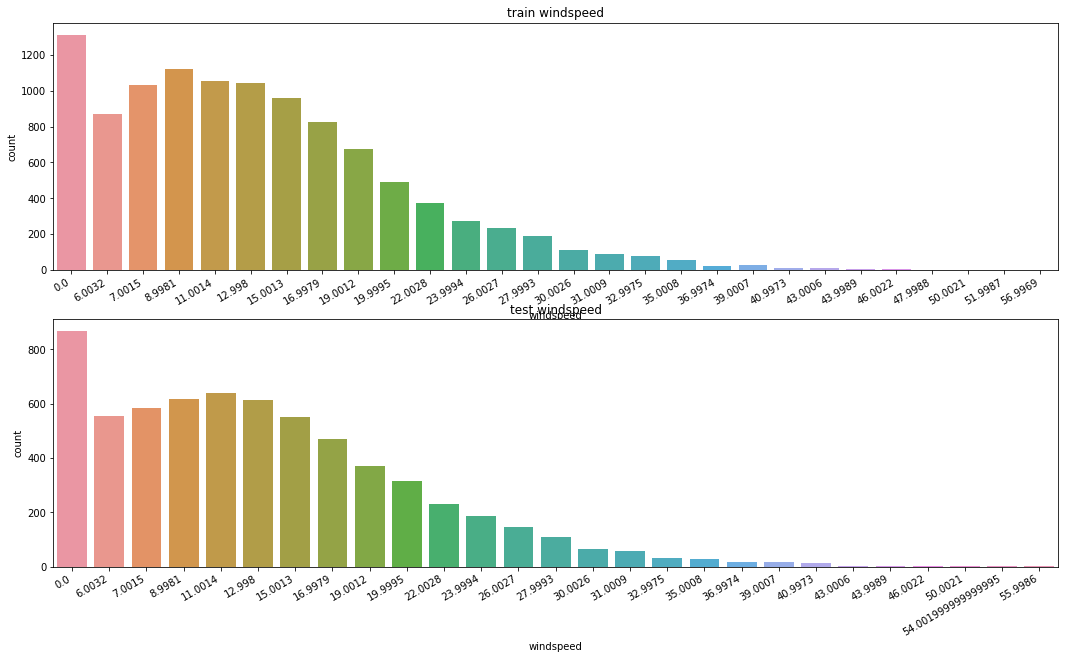

In [8]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1]) # 풍속 데이터 시각화, 측정되지 않은 값은 아마 0으로 측정했을 것 같다는 추측

In [9]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [10]:
trainWind0 = train.loc[train["windspeed"] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape) # 풍속이 0인것과 아닌 것으로 나눔

(1313, 19)
(9573, 19)


In [18]:
from sklearn.ensemble import RandomForestClassifier # 머신러닝으로 예측

def predict_windspeed(data):
  dataWind0 = data.loc[data['windspeed'] == 0]
  dataWindNot0 = data.loc[data['windspeed'] != 0] # 풍속이 0인것과 아닌것

  wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"] # 풍속을 예측할 피처를 선택
  dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype('str') # 풍속이 0이 아닌 데이터의 타입을 str으로 바꿔줌
  rfModel_wind = RandomForestClassifier() # 랜덤포레스트 분류기 사용
  rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"]) # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다
  wind0Values = rfModel_wind.predict(X = dataWind0[wCol]) # 풍속이 0으로 기록된 데이터의 풍속 예측

  predictWind0 = dataWind0
  predictWindNot0 = dataWindNot0 # 데이터프레임 새로 만든다.
  predictWind0["windspeed"] = wind0Values # 0으로 기록된 풍속에 대해 예측값 넣어줌
  data = predictWindNot0.append(predictWind0) # 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다
  data["windspeed"] = data["windspeed"].astype("float") # float으로 지정해줌
  data.reset_index(inplace=True)
  data.drop('index', inplace=True, axis=1)

  return data

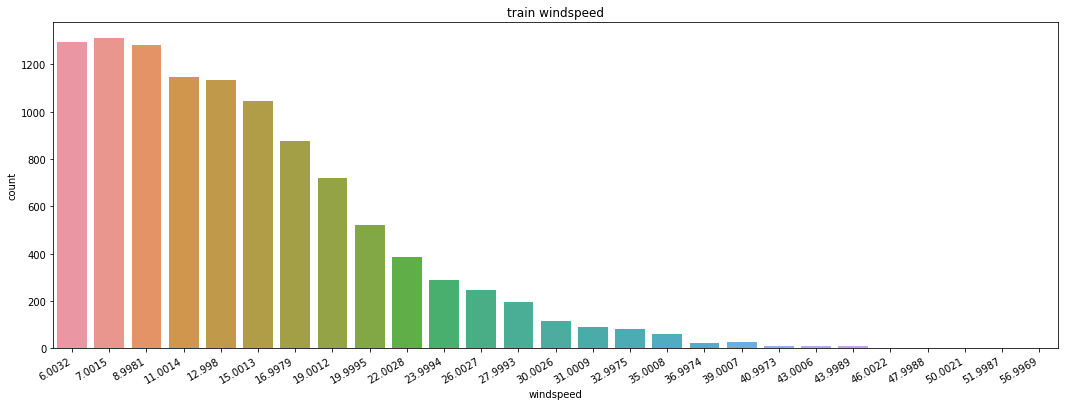

In [19]:
# 0값을 조정한다.
train = predict_windspeed(train) 
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6) # windspeed의 0값을 조정한 데이터를 시각화

plt.sca(ax1)
plt.xticks(rotation=30, ha='right') # rotation=30 은 글씨 기울임
ax1.set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x= "windspeed", ax=ax1)

In [20]:
# feature selection

In [21]:
# 연속형 feature과 범주형 feature
# 연속형 feature = ["temp", "humidity", "windspeed", "atemp"]
# 범주형 feature의 type을 category로 변경
categorical_feature_names = ["season", "holiday", "workingday", "weather",
                             "dayofweek", "month", "year", "hour"]

for var in categorical_feature_names:
  train[var] = train[var].astype("category")
  test[var] = test[var].astype("category")

In [22]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [23]:
X_train = train[feature_names] # X_train이라는 새로운 행을 만든다

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [24]:
X_test = test[feature_names] # X_test라는 새로운 행을 만든다

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [26]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head() # 이 값을 바탕으로 test의 count값 예측할 것이다

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [27]:
# score. RMSLE이라는 평가방법 사용

In [28]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # numpy로 배열 형태로 바꿔주기
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 각각 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0) # KFold 방식으로 교차검증한다.

In [30]:
# RandomForest

In [31]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = [ ]

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0) # n_estimator 값을 높일수록 예측을 하는데 시간이 오래걸림
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [32]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print("Score={0:.5f}".format(score)) # 0에 근접할수록 좋은 데이터

CPU times: user 3.22 s, sys: 675 ms, total: 3.89 s
Wall time: 30.4 s
Score=0.33082


In [33]:
# Train

In [34]:
model.fit(X_train, y_train) # 학습시킴

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [37]:
predictions = model.predict(X_test) # 예측

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.64,   5.04,   3.97,   3.54,   3.19,   6.31,  38.27, 104.99,
       236.39, 136.23])

[Text(0.5, 1.0, 'test')]

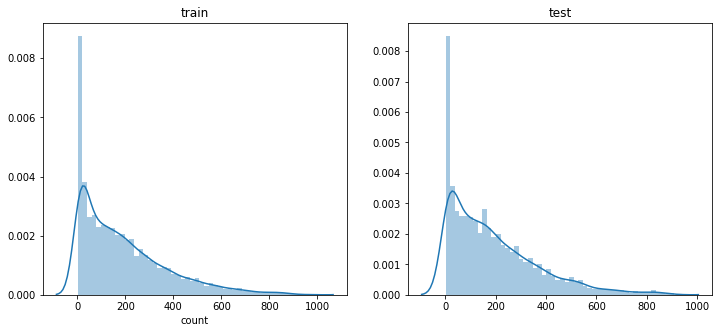

In [39]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test") # distplot형식으로 예측된 데이터를 시각화함

In [41]:
# submit

In [42]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head() # submission의 count 예상한 값 넣어주기

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.64
1,2011-01-20 01:00:00,5.04
2,2011-01-20 02:00:00,3.97
3,2011-01-20 03:00:00,3.54
4,2011-01-20 04:00:00,3.19


In [43]:
submission.to_csv("/content/drive/My Drive/Colab Notebooks/data/Score_{0:.5f}_submission.csv".format(score), index=False)

In [44]:
431/3501 # 상위 12%

0.12310768351899458